In [ ]:
Module 3 Project, V2.1

Build a classifier to predict whether a customer will ("soon") stop doing business with SyriaTel, 
a telecommunications company. Note that this is a binary classification problem.

Most naturally, your audience here would be the telecom business itself, interested in losing money
on customers who don't stick around very long. Are there any predictable patterns here?

Target Variable:
Churn: if the customer has churned (1=yes; 0 = no)

structure

- descriptive values
- churn percentage
- EDA: bar chart by state, zip code, etc.
- change intl plan, vm plan to binary. one hot endcode states
- remove redundant columns, target
- build feature matrix and standardize
- cross validation (necessary bc target size is not balanced)
- build five models
- ROC curve to figure out which model will do best on true positives 
- confusion matrix for each model
- classification matrix for each model
- get feature importance from whichever model performs best

In [ ]:
set up
% of customers churn within the month

goal is to protect the profits of the company - acquiring new customers is assumed to be more expensive than retaining currecnt customers
model should accurately predict which customers will churn

worst case scenario is spending on ALL customers
this will allow for decrease in targeting $$

In [115]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics, ensemble
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE


from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [58]:
df = pd.read_csv('churn_data.csv')
df.head(10)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,...,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,...,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,...,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,...,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,...,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


In [37]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [38]:
#check for missing values
df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

In [40]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [59]:
# naming a new df, so we don't modify the original dataframe
df_copy = df.copy()

df_copy.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


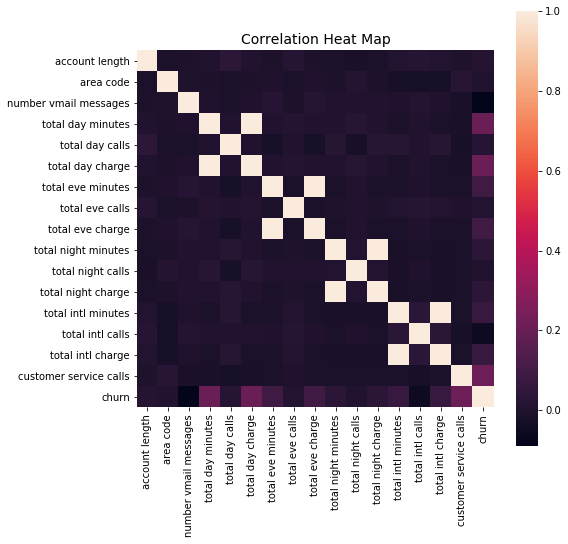

In [42]:
corrmat = df_copy.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

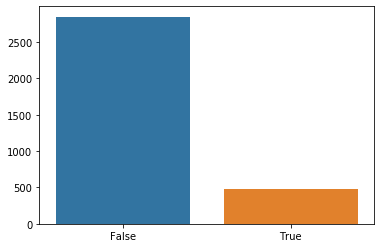

In [43]:
y = df_copy["churn"].value_counts()
sns.barplot(y.index, y.values)

In [44]:
y_True = df_copy["churn"][df_copy["churn"] == True]
print ("Churn Percentage = "+str( (y_True.shape[0] / df_copy["churn"].shape[0]) * 100 ))

Churn Percentage = 14.491449144914492


That's not great - almost 15% of this company's customers churn in any given month!
This also means that our data is imbalanced; we only have about 15% of our dataset available to help predict which customers will churn. We'll have to account for this later when building our models.

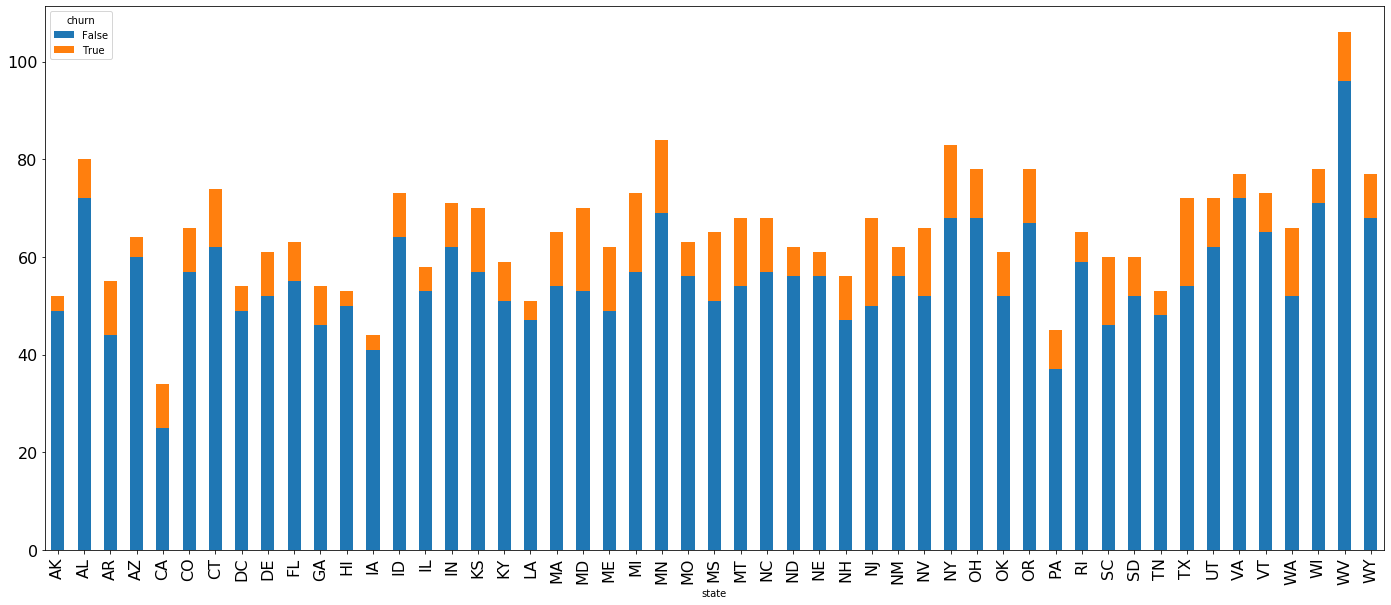

In [45]:
df_copy.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(24,10),fontsize=16) 

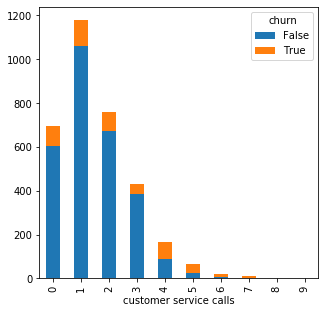

In [46]:
df_copy.groupby(["customer service calls", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

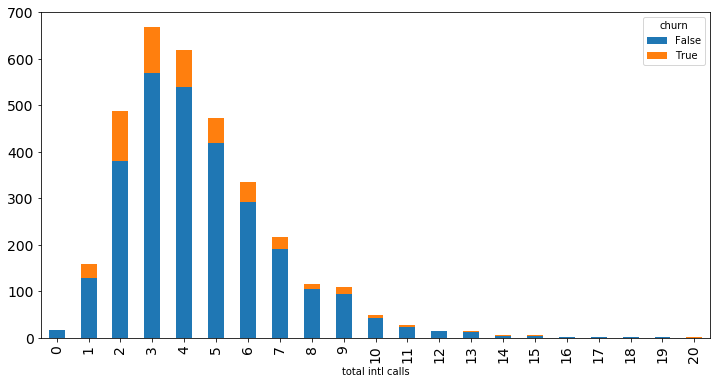

In [47]:
df_copy.groupby(["total intl calls", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=14) 

In [ ]:
# add chart - total of monthly charges
https://towardsdatascience.com/churn-prediction-770d6cb582a5

Interesting - the churn showed above in orange is pretty well distributed! Nothing glaringly obvious yet. Let's move onto building a model.

In [60]:
# One hot encoding state data

# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
df_copy.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [61]:
df_copy['state'] = label_encoder.fit_transform(df_copy['state'])
df_copy.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,35,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,31,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,35,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,36,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [62]:
df_copy = pd.get_dummies(df_copy, columns=['state'])
df_copy.head()

,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,...,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49,state_50
0,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,...,0,0,0,0,0,0,0,0,0,0
1,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,...,0,0,0,0,0,0,0,0,0,0
2,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,...,0,0,0,0,0,0,0,0,0,0
3,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,...,0,0,0,0,0,0,0,0,0,0
4,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# change values to binary/numerical so they can be interpreted

df_copy['international plan'] = label_encoder.fit_transform(df_copy['international plan'])
df_copy['voice mail plan'] = label_encoder.fit_transform(df_copy['voice mail plan'])

In [64]:
df_copy.head()

,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,...,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49,state_50
0,128,415,382-4657,0,1,25,265.1,110,45.07,197.4,...,0,0,0,0,0,0,0,0,0,0
1,107,415,371-7191,0,1,26,161.6,123,27.47,195.5,...,0,0,0,0,0,0,0,0,0,0
2,137,415,358-1921,0,0,0,243.4,114,41.38,121.2,...,0,0,0,0,0,0,0,0,0,0
3,84,408,375-9999,1,0,0,299.4,71,50.90,61.9,...,0,0,0,0,0,0,0,0,0,0
4,75,415,330-6626,1,0,0,166.7,113,28.34,148.3,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# remove duplicate info (phone number) as well as target (churn)

df_copy = df_copy.drop(["phone number","churn"], axis = 1)
df_copy.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49,state_50
0,128,415,0,1,25,265.1,110,45.07,197.4,99,...,0,0,0,0,0,0,0,0,0,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,...,0,0,0,0,0,0,0,0,0,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,...,0,0,0,0,0,0,0,0,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,...,0,0,0,0,0,0,0,0,0,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Looks great! Let's move on to preparing our data.

In [131]:
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(df_copy, y, test_size = 0.25, random_state = 0,stratify=y)

In [132]:
X = df_copy.as_matrix().astype(np.float)
X

array([[128., 415.,   0., ...,   0.,   0.,   0.],
       [107., 415.,   0., ...,   0.,   0.,   0.],
       [137., 415.,   0., ...,   0.,   0.,   0.],
       ...,
       [ 28., 510.,   0., ...,   0.,   0.,   0.],
       [184., 510.,   1., ...,   0.,   0.,   0.],
       [ 74., 415.,   0., ...,   0.,   0.,   0.]])

In [133]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.67648946, -0.52360328, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       [ 0.14906505, -0.52360328, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       [ 0.9025285 , -0.52360328, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       ...,
       [-1.83505538,  1.71881732, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       [ 2.08295458,  1.71881732,  3.05268496, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       [-0.67974475, -0.52360328, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117]])

In [134]:
# determine imbalance solution

LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.7139142528874646
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.7401463385136361
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 2}, dual=False,
                   fit_inte

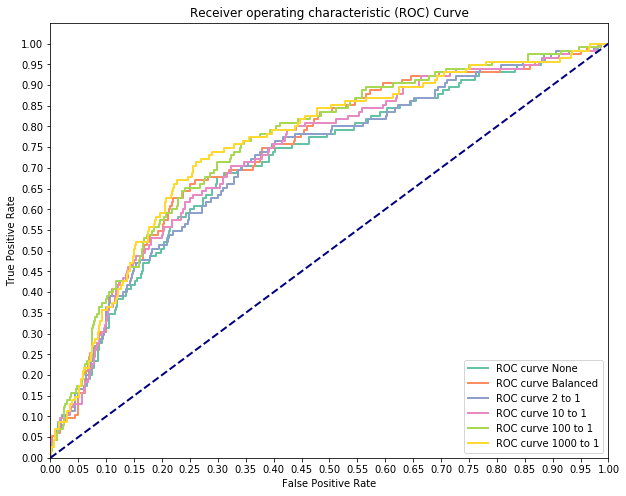

In [135]:
# Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=1e20, class_weight=weight, solver='lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Relatively speaking, these curves are close together. Going with the best result (1000:1) is only a 3% improvement on leaving as is! From this we can gather that our model has sufficient target information to make accurate predictions. Let's move on.

In [136]:
# iterate through different models
# build pipeline for these

In [137]:
# add in grid search for this?

In [138]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(f'Logistic Regression: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(classification_report(y_train, preds))

Logistic Regression: 0.8573141486810552
AUC: 0.5300901009856686
Precision: 0.4090909090909091
Recall: 0.0782608695652174


ValueError: Found input variables with inconsistent numbers of samples: [2499, 834]

In [129]:
y_train.shape

(2499,)

In [130]:
preds.shape

(834,)

In [112]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')

Decision Tree: 0.9304556354916067
AUC: 0.8838454672956778
Precision: 0.7333333333333333
Recall: 0.8181818181818182


In [111]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(f'Gradient Boosting: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')

Gradient Boosting: 0.9616306954436451
AUC: 0.8952163481042736
Precision: 0.9238095238095239
Recall: 0.8016528925619835


In [140]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(f'XGB Classifier: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')

XGB Classifier: 0.960431654676259
AUC: 0.9040031444639295
Precision: 0.8796296296296297
Recall: 0.8260869565217391


In [ ]:
# add in confusion matricies

In [141]:
clf.feature_importances_

array([0.01193465, 0.01203749, 0.07190984, 0.0705692 , 0.02145242,
       0.03706726, 0.01118878, 0.04076065, 0.02688735, 0.01055803,
       0.01357408, 0.01811539, 0.01231634, 0.01671965, 0.02367032,
       0.03329309, 0.02000855, 0.05793219, 0.        , 0.00756074,
       0.        , 0.        , 0.01536149, 0.        , 0.05108174,
       0.02323504, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01521206, 0.        , 0.06017748, 0.02551768,
       0.01900612, 0.01608978, 0.        , 0.02760672, 0.02094958,
       0.        , 0.        , 0.        , 0.        , 0.02319565,
       0.0348928 , 0.        , 0.        , 0.01772502, 0.        ,
       0.04701709, 0.0099674 , 0.        , 0.01657527, 0.01557665,
       0.        , 0.03128914, 0.        , 0.00517193, 0.00679541,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

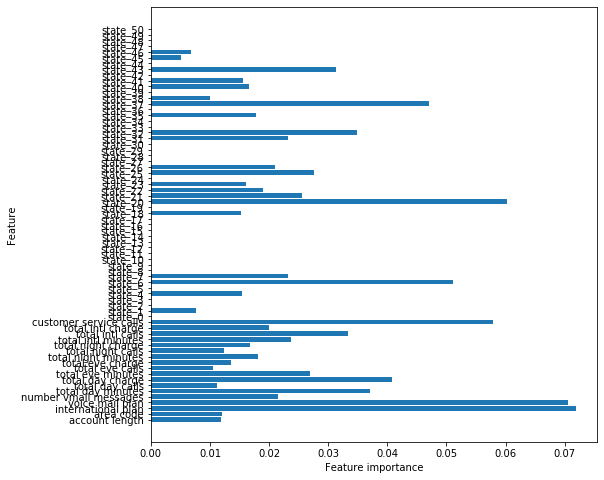

In [149]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)